# Surfing boundary problem

> modified from [Aditya's script of nuc22](../../nuc22/surfing/Surfing_Graphite_12b.py)



## Importing libs

In [1]:
# copying from ../Brazilian_test/Brazilian_test.ipynb
from mpi4py import MPI
from dolfinx import mesh, fem, io, plot, nls, log, geometry, la
from dolfinx import cpp as _cpp
from dolfinx import default_real_type
import basix
import dolfinx.fem.petsc
import ufl
import numpy as np
from petsc4py.PETSc import ScalarType
from petsc4py import PETSc
import time
import os
import gmsh

log.set_log_level(log.LogLevel.ERROR)
comm = MPI.COMM_WORLD
comm_rank = MPI.COMM_WORLD.rank
print(dolfinx.dolfin_version())

AttributeError: module 'dolfinx' has no attribute 'dolfin_version'

## Properties

In [2]:
# material properties of Graphite (MPa, mm, N/mm)
E, nu = ScalarType(9800), ScalarType(0.13)
mu, lmbda, kappa = (
    E / (2 * (1 + nu)),
    E * nu / ((1 + nu) * (1 - 2 * nu)),
    E / (3 * (1 - 2 * nu)),
)
Gc = ScalarType(0.091)
sts = ScalarType(27)
scs = ScalarType(77)
shs = (2 / 3) * sts * scs / (scs - sts)
Wts = sts**2 / (2 * E)
Whs = shs**2 / (2 * kappa)

lch = 3 * Gc * E / 8 / (sts**2)  # Irwin length
eps = 0.4
h = eps / 4
delta = (1 + 3 * h / (8 * eps)) ** (-2) * ((sts + (1 + 2 * np.sqrt(3)) * shs) / ((8 + 3 * np.sqrt(3)) * shs)) * 3 * Gc / (16 * Wts * eps) + (
    1 + 3 * h / (8 * eps)
) ** (-1) * (2 / 5)

print(f"lch={lch:.2f}")
print(f"l={eps}, h={h:.2f}")
print(f"delta={delta:.2f}")

lch=0.46
l=0.4, h=0.10
delta=0.76


## Mesh and function spaces

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00120011s, CPU 0.00148s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.014327s, CPU 0.009667s)
Info    : 30401 nodes 30804 elements
Info    : Writing './mesh/surf_quad.msh'...
Info    : Done writing './mesh/surf_quad.msh'


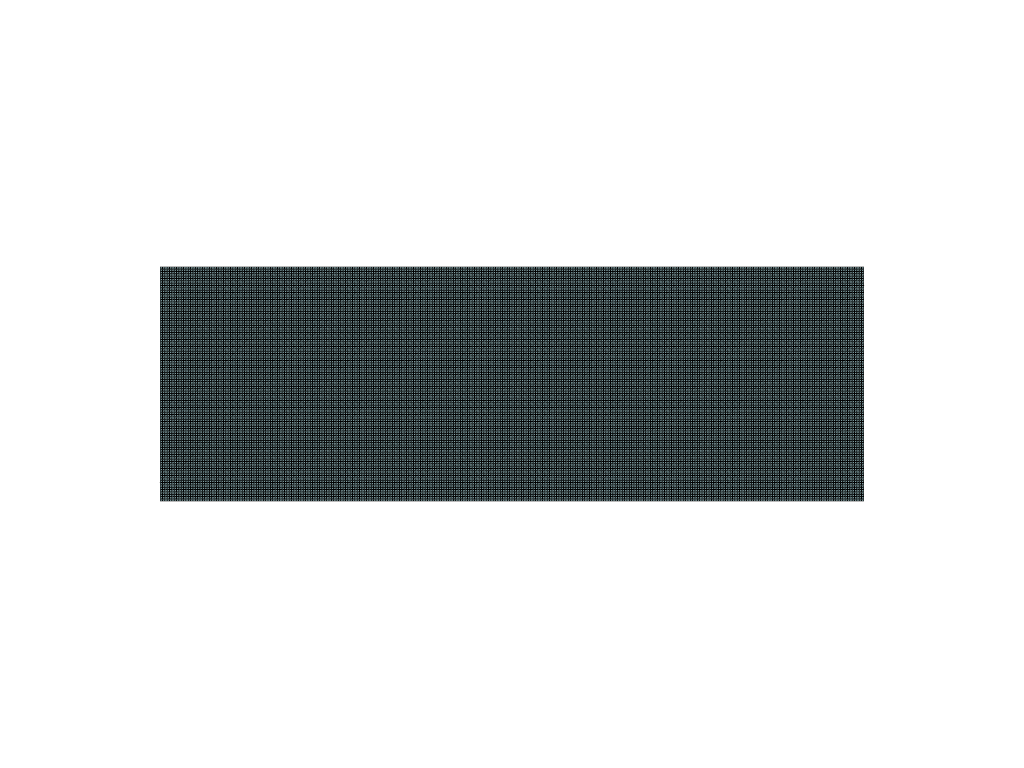

In [3]:
import pyvista

pyvista.set_jupyter_backend("static")
pyvista.start_xvfb()


# gmsh mesh
def surf_quad_mesh(xlim: list[float], ylim: list[float], h: float, mesh_path: str):
    gmsh.initialize()
    gmsh.model.add(f"Surfing")

    # nx, ny for transfinite
    nx = int(abs(xlim[1] - xlim[0]) / h) + 1
    ny = int(abs(ylim[1] - ylim[0]) / h) + 1

    # points
    p1 = gmsh.model.geo.addPoint(xlim[0], ylim[0], 0, h)
    p2 = gmsh.model.geo.addPoint(xlim[1], ylim[0], 0, h)
    p3 = gmsh.model.geo.addPoint(xlim[1], ylim[1], 0, h)
    p4 = gmsh.model.geo.addPoint(xlim[0], ylim[1], 0, h)

    # lines
    l1 = gmsh.model.geo.addLine(p1, p2)
    l2 = gmsh.model.geo.addLine(p2, p3)
    l3 = gmsh.model.geo.addLine(p3, p4)
    l4 = gmsh.model.geo.addLine(p4, p1)

    # curve loop and plane surface
    cl = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
    ps = gmsh.model.geo.addPlaneSurface([cl])

    # transfinite
    gmsh.model.geo.mesh.setTransfiniteCurve(l1, nx)
    gmsh.model.geo.mesh.setTransfiniteCurve(l2, ny)
    gmsh.model.geo.mesh.setTransfiniteCurve(l3, nx)
    gmsh.model.geo.mesh.setTransfiniteCurve(l4, ny)
    gmsh.model.geo.mesh.setTransfiniteSurface(ps, cornerTags=[p1, p2, p3, p4])
    gmsh.model.geo.mesh.setRecombine(2, ps)

    # physical groups for boundaries
    # gmsh.model.addPhysicalGroup(1, [l4], name="left")
    # gmsh.model.addPhysicalGroup(1, [l2], name="right")
    # gmsh.model.addPhysicalGroup(1, [l3], name="top")
    # gmsh.model.addPhysicalGroup(1, [l1], name="bottom")
    gmsh.model.addPhysicalGroup(2, [cl], name="surfing")

    # synchronize
    gmsh.model.geo.synchronize()

    # Generate 2D mesh
    gmsh.model.mesh.generate(2)
    gmsh.model.mesh.setOrder(1)

    # save to msh and fenics xdmf
    gmsh.write(f"{mesh_path}.msh")
    domain, cell_markers, facet_markers = io.gmshio.model_to_mesh(gmsh.model, comm, comm_rank, gdim=2)

    with dolfinx.io.XDMFFile(domain.comm, f"{mesh_path}.xdmf", "w") as xdmf:
        xdmf.write_mesh(domain)

    # Optional: Launch the Gmsh GUI to view the mesh
    # gmsh.fltk.run()
    gmsh.finalize()
    return domain


def plot_fenics_mesh(mesh_path: str):
    with dolfinx.io.XDMFFile(MPI.COMM_WORLD, f"{mesh_path}.xdmf", "r") as xdmf:
        mesh = xdmf.read_mesh()
        topology, cell_types, x = dolfinx.plot.vtk_mesh(mesh)
        grid = pyvista.UnstructuredGrid(topology, cell_types, x)
        plotter = pyvista.Plotter()
        plotter.add_mesh(grid, show_edges=True)
        plotter.camera_position = "xy"
        plotter.show()


# mesh gen
mesh_path = "./mesh/surf_quad"
xlim = [0, 30]
ylim = [-5, 5]
h = 0.1
domain = surf_quad_mesh(xlim, ylim, h, mesh_path)

# plot to check mesh
plot_fenics_mesh(mesh_path)

## Function spaces

In [4]:
V = fem.functionspace(domain, ("CG", 1, (domain.geometry.dim,)))  # Function space for u
Y = fem.functionspace(domain, ("CG", 1))  # Function space for damage
V_plot = fem.functionspace(domain, ("CG", 1, (domain.geometry.dim,)))
print(V)
print(Y)

FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, equispaced, unset, False), (2,)), 0), blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False), (2,)))
FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, equispaced, unset, False), (2,)), 0), Basix element (P, quadrilateral, 1, gll_warped, unset, False))


## BCs

In [5]:
from math import sqrt, pi, cos, sin, atan2
import numpy as np


def top(x):
    return np.isclose(x[1], 5)


def bottom(x):
    return np.isclose(x[1], -5)


def leftbot(x):
    # fix point at left bottom
    return (np.abs(x[0]) < 1e-4) & (np.abs(x[1] + 5) < 1e-4)


def center(x):
    # for intial crack at x in [0, 5], y=0
    return (np.abs(x[1]) < 1e-4) & (np.abs(x[0]) >= 0) & (np.abs(x[0]) <= 5)


# c1 = (1 + nu) * sqrt(Gc) / sqrt(2 * pi * E)
# c2 = (3 - nu) / (1 + nu)
# ahead = 2
# vel = 20

# load = fem.Expression(
#     "c1*((x[0]-V*t-ahead)^2+x[1]^2)^(0.25)*(c2-cos(atan2(x[1],(x[0]-V*t-ahead))))*sin(0.5*atan2(x[1],(x[0]-V*t-ahead)))",
#     # degree=4,
#     t=0,
#     V=vel,
#     ahead=ahead,
# )


class MyExpression:
    def __init__(self):
        self.t = 0.0

    def eval(self, x):
        values = np.zeros((2, x.shape[1]))
        vel = 20
        ahead = 2
        c1 = (1 + nu) * sqrt(Gc) / sqrt(2 * pi * E)
        c2 = (3 - nu) / (1 + nu)
        values[1, :] = (
            c1
            * ((x[0] - vel * self.t - ahead) ** 2 + x[1] ** 2) ** (0.25)
            * (c2 - np.cos(np.arctan2(x[1], (x[0] - vel * self.t - ahead))))
            * np.sin(0.5 * np.arctan2(x[1], (x[0] - vel * self.t - ahead)))
        )
        return values


load_exp = MyExpression()
load_exp.t = 0
load_value = fem.Function(V)
load_value.interpolate(load_exp.eval)

# get facet
fdim = domain.topology.dim - 1
top_facets = mesh.locate_entities_boundary(domain, fdim, top)
bot_facets = mesh.locate_entities_boundary(domain, fdim, bottom)
fix_facets = mesh.locate_entities(domain, fdim, leftbot)
center_facets = mesh.locate_entities(domain, fdim, center)

# get dofs
top_dofs = fem.locate_dofs_topological(V, fdim, top_facets)
bot_dofs = fem.locate_dofs_topological(V, fdim, bot_facets)
fix_dof = fem.locate_dofs_topological(V.sub(0), fdim, fix_facets)
center_dof = fem.locate_dofs_topological(Y, fdim, center_facets)

# bcs for disp
bc_top = fem.dirichletbc(load_value, top_dofs)
bc_bot = fem.dirichletbc(load_value, bot_dofs)
bc_fix = fem.dirichletbc(ScalarType(0), fix_dof, V.sub(0))
bcs = [bc_top, bc_bot, bc_fix]

# bcs for d # NOTE: Adity set d=0 at bottom and top, we don't need it
bc_z_center = fem.dirichletbc(ScalarType(0), center_dof, Y)
bcs_z = [bc_z_center]

## Trial and test functions

In [6]:
metadata = {"quadrature_degree": 4}
dx = ufl.Measure("dx", domain=domain, metadata=metadata)

du = ufl.TrialFunction(V)  # incremetnal displacement
v = ufl.TestFunction(V)  # test function
u = fem.Function(V, name="displacement")  # displacement for prvious iteration
u_inc = fem.Function(V)

dz = ufl.TrialFunction(Y)  # incremental phase field
y = ufl.TestFunction(Y)  # test function
z = fem.Function(Y, name="phasefield")  # phase field from previous iteration
z_inc = fem.Function(Y)
d = len(u)

## ICs

In [7]:
# initialize and apply bcs
u.x.array[:] = 0.0
fem.petsc.set_bc(u.vector, bcs)

z.x.array[:] = 1.0
fem.petsc.set_bc(z.vector, bcs_z)

u_prev = fem.Function(V)
u_prev.x.array[:] = u.x.array
z_prev = fem.Function(Y)
z_prev.x.array[:] = z.x.array

z_trial = fem.Function(Y)
z_trial.x.array[:] = z.x.array
zdif = fem.Function(Y)
zdif.x.array[:] = 0

## Energy, strain and stress

In [8]:
def energy(v):
    """input displacements, calculate strain energy"""
    return (
        mu * (ufl.inner(ufl.sym(ufl.grad(v)), ufl.sym(ufl.grad(v))) + ((nu / (1 - nu)) ** 2) * (ufl.tr(ufl.sym(ufl.grad(v)))) ** 2)
        + 0.5 * (lmbda) * (ufl.tr(ufl.sym(ufl.grad(v))) * (1 - 2 * nu) / (1 - nu)) ** 2
    )


def epsilon(v):
    return ufl.sym(ufl.grad(v))


def sigma(v):
    return 2.0 * mu * ufl.sym(ufl.grad(v)) + (lmbda) * ufl.tr(ufl.sym(ufl.grad(v))) * (1 - 2 * nu) / (1 - nu) * ufl.Identity(len(v))


def sigmavm(sig, v):
    return ufl.sqrt(
        1
        / 2
        * (
            ufl.inner(
                sig - 1 / 3 * ufl.tr(sig) * ufl.Identity(len(v)),
                sig - 1 / 3 * ufl.tr(sig) * ufl.Identity(len(v)),
            )
            + (1 / 9) * ufl.tr(sig) ** 2
        )
    )


def sdev(sig, v):
    return sig - 1 / 3 * ufl.tr(sig) * ufl.Identity(len(v))


def sigma3(sdev):
    return ufl.tr(sdev * sdev * sdev)


eta = 0
# Stored strain energy density
psi1 = (z**2 + eta) * (energy(u))
psi11 = 2 * z * energy(u)  # NOTE: here Aditya used psi11=energy(u)

# Total potential energy
Pi = psi1 * dx

# frist variation
R = ufl.derivative(Pi, u, v)

Jac = ufl.derivative(R, u, du)

## Ce

In [9]:
I1 = (z**2) * ufl.tr(sigma(u))
SQJ2 = (z**2) * sigmavm(sigma(u), u)

alpha1 = (delta * Gc) / (shs * 8 * eps) - (2 * Whs) / (3 * shs)
alpha2 = (3**0.5 * (3 * shs - sts) * delta * Gc) / (shs * sts * 8 * eps) + (2 * Whs) / (3**0.5 * shs) - (2 * 3**0.5 * Wts) / (sts)

ce = alpha2 * SQJ2 + alpha1 * I1 - z * (1 - ufl.sqrt(I1**2) / I1) * psi11
print(ce)

-0.0013126636598104393 * phasefield ** 2 * (tr(({ A | A_{i_8, i_9} = 8672.566371681416 * (sym(grad(displacement)))[i_8, i_9] }) + ({ A | A_{i_{10}, i_{11}} = I[i_{10}, i_{11}] * 0.74 * 1523.5589571872758 * (tr(sym(grad(displacement)))) / 0.87 }))) + 0.001665258679323804 * phasefield ** 2 * sqrt(0.5 * (0.1111111111111111 * (tr(({ A | A_{i_{12}, i_{13}} = 8672.566371681416 * (sym(grad(displacement)))[i_{12}, i_{13}] }) + ({ A | A_{i_{14}, i_{15}} = I[i_{14}, i_{15}] * 0.74 * 1523.5589571872758 * (tr(sym(grad(displacement)))) / 0.87 }))) ** 2 + ((({ A | A_{i_{18}, i_{19}} = -1 * ({ A | A_{i_{16}, i_{17}} = I[i_{16}, i_{17}] * 0.3333333333333333 * (tr(({ A | A_{i_{12}, i_{13}} = 8672.566371681416 * (sym(grad(displacement)))[i_{12}, i_{13}] }) + ({ A | A_{i_{14}, i_{15}} = I[i_{14}, i_{15}] * 0.74 * 1523.5589571872758 * (tr(sym(grad(displacement)))) / 0.87 }))) })[i_{18}, i_{19}] }) + ({ A | A_{i_{12}, i_{13}} = 8672.566371681416 * (sym(grad(displacement)))[i_{12}, i_{13}] }) + ({ A | A_{i_

## Weak form of phase-field

In [10]:
# NOTE： Adtiya used pen = 180*160*Gc/lch, what is the coefficietn here?
pen = 1000 * (3 * Gc / 8 / eps) * ufl.conditional(ufl.lt(delta, 1), 1, delta)
Wv = pen / 2 * ((abs(z) - z) ** 2 + (abs(1 - z) - (1 - z)) ** 2) * dx
Wv2 = ufl.conditional(ufl.le(z, 0.1), 1, 0) * 100 * pen / 2 * ((1 / 4) * (abs(z_prev - z) - (z_prev - z)) * 2) * dx
R_z = (
    y * 2 * z * (psi11) * dx
    + y * (ce) * dx
    + 3 * delta * Gc / 8 * (-y / eps + 2 * eps * ufl.inner(ufl.grad(z), ufl.grad(y))) * dx
    + ufl.derivative(Wv, z, y)
    + ufl.derivative(Wv2, z, y)
)
Jac_z = ufl.derivative(R_z, z, dz)

## Nolinear solver

In [11]:
class NonlinearPDEProblem:
    """Nonlinear problem class for a PDE problem."""

    def __init__(self, F, u, bc, J):
        # V = u.function_space
        # du = TrialFunction(V)
        self.L = fem.form(F)
        self.a = fem.form(J)
        self.bc = bc

    def form(self, x):
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

    def F(self, x, b):
        """Assemble residual vector."""
        with b.localForm() as b_local:
            b_local.set(0.0)
        fem.petsc.assemble_vector(b, self.L)
        fem.petsc.apply_lifting(b, [self.a], bcs=[self.bc], x0=[x], scale=-1.0)
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        fem.petsc.set_bc(b, self.bc, x, -1.0)

    def J(self, x, A):
        """Assemble Jacobian matrix."""
        A.zeroEntries()
        fem.petsc.assemble_matrix(A, self.a, bcs=self.bc)
        A.assemble()

    def matrix(self):
        return fem.petsc.create_matrix(self.a)

    def vector(self):
        return fem.petsc.create_vector(self.L)

## Time stepper

In [12]:
# time-stepping parameters
T = 0.3
Totalsteps = 30
# minstepsize = 1 / Totalsteps / 1000
# maxstepsize = 1 / Totalsteps * 10
startstepsize = 1 / Totalsteps
stepsize = startstepsize
t = stepsize
step = 1
samesizecount = 1
# other time stepping parameters
terminate = 0
printsteps = 1
minstepsize = startstepsize / 10000
maxstepsize = startstepsize

## Newton solvers

In [13]:
# Create nonlinear problem
problem_u = NonlinearPDEProblem(R, u, bcs, Jac)

# Create Newton solver and solve

solver = _cpp.nls.petsc.NewtonSolver(MPI.COMM_WORLD)
solver.setF(problem_u.F, problem_u.vector())
solver.setJ(problem_u.J, problem_u.matrix())
solver.set_form(problem_u.form)
solver.max_it = 10
# solver.convergence_criterion = "incremental"
solver.error_on_nonconvergence = False
solver.atol = 1.0e-8
solver.rtol = 1.0e-7

ksp1 = solver.krylov_solver
opts = PETSc.Options()  # type: ignore
option_prefix = ksp1.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"

# Create nonlinear problem
problem_z = NonlinearPDEProblem(R_z, z, bcs_z, Jac_z)

# Create Newton solver and solve

solver_z = _cpp.nls.petsc.NewtonSolver(MPI.COMM_WORLD)
solver_z.setF(problem_z.F, problem_z.vector())
solver_z.setJ(problem_z.J, problem_z.matrix())
solver_z.set_form(problem_z.form)
solver_z.max_it = 10
# solver_z.convergence_criterion = "incremental"
solver_z.error_on_nonconvergence = False
solver_z.atol = 1.0e-8
solver_z.rtol = 1.0e-7


ksp2 = solver_z.krylov_solver
opts = PETSc.Options()  # type: ignore
option_prefix = ksp2.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"

## Staggered scheme

In [14]:
while t - stepsize < T:

    terminate = 0

    if comm_rank == 0:
        print("Step= %d" % step, "t= %f" % t, "Stepsize= %e" % stepsize)

    # re1.t = t
    # c1.interpolate(re1.eval)
    # re2.t = t
    # c2.interpolate(re2.eval)
    load_exp.t = t
    load_value.interpolate(load_exp.eval)

    fdim = domain.topology.dim - 1
    top_facets = mesh.locate_entities_boundary(domain, fdim, top)
    bot_facets = mesh.locate_entities_boundary(domain, fdim, bottom)
    fix_facets = mesh.locate_entities(domain, fdim, leftbot)

    top_dofs = fem.locate_dofs_topological(V, fdim, top_facets)
    bot_dofs = fem.locate_dofs_topological(V, fdim, bot_facets)
    fix_dof = fem.locate_dofs_topological(V.sub(0), fdim, fix_facets)

    bc_top = fem.dirichletbc(load_value, top_dofs)
    bc_bot = fem.dirichletbc(load_value, bot_dofs)
    bc_fix = fem.dirichletbc(ScalarType(0), fix_dof, V.sub(0))

    problem_u.bc = [bc_top, bc_bot, bc_fix]

    # y_dofs_top = fem.locate_dofs_topological(V.sub(1), fdim, loading1_facets)
    stag_iter = 1
    rnorm_stag = 1
    norm_z = 1
    while stag_iter < 50 and norm_z > 1e-7:
        start_time = time.time()
        ##############################################################
        # PDE for u
        ##############################################################
        solver.solve(u.vector)
        u.x.scatter_forward()
        z_trial.x.array[:] = z.x.array
        ##############################################################
        # PDE for z
        ##############################################################
        solver_z.solve(z.vector)
        z.x.scatter_forward()
        ##############################################################

        zmin = domain.comm.allreduce(np.min(z.x.array), op=MPI.MIN)

        if comm_rank == 0:
            print(f"zmin={zmin}")

        if comm_rank == 0:
            print("--- %s seconds ---" % (time.time() - start_time))

        ###############################################################
        # Residual check for stag loop
        ###############################################################
        b_e = fem.petsc.assemble_vector(fem.form(-R))
        fint = b_e.copy()
        fem.petsc.set_bc(b_e, bcs)

        rnorm_stag = b_e.norm()
        zdif.x.array[:] = z.x.array - z_trial.x.array
        norm_z = zdif.x.norm()
        if comm_rank == 0:
            print("Iteration number for u= %d" % stag_iter, "Residual= %e" % rnorm_stag)
            print("Iteration number for z= %d" % stag_iter, "Residual= %e" % norm_z)
        stag_iter += 1

    ########### Post-processing ##############

    if terminate == 1:
        u.x.array[:] = u_prev.x.array
        z.x.array[:] = z_prev.x.array
    else:
        u_prev.x.array[:] = u.x.array
        z_prev.x.array[:] = z.x.array

        ####Calculate Reaction
        # Fx = domain.comm.allreduce(np.sum(b_e[y_dofs_top]), op=MPI.SUM)
        # z_x = evaluate_function(z, (0.0, 0.0))

        # if comm_rank == 0:
        #     print(Fx)
        #     print(z_x)
        #     with open("PF_R15S5_formula.txt", "a") as rfile:
        #         rfile.write("%s %s %s\n" % (str(t), str(zmin), str(Fx)))

        if step % printsteps == 0:
            u.name = "Deformation"
            z.name = "phasefield"
            with io.XDMFFile(domain.comm, "out/fenics_" + str(step) + ".xdmf", "w") as file_results:
                file_results.write_mesh(domain)
                file_results.write_function(u, t)
                file_results.write_function(z, t)

    # time stepping
    if terminate == 1:
        if stepsize > minstepsize:
            t -= stepsize
            stepsize /= 2
            t += stepsize
            samesizecount = 1
        else:
            break
    else:
        if samesizecount < 2:
            step += 1
            if t + stepsize <= T:
                samesizecount += 1
                t += stepsize
            else:
                samesizecount = 1
                stepsize = T - t
                t += stepsize
        else:
            step += 1
            if stepsize * 2 <= maxstepsize and t + stepsize * 2 <= T:
                stepsize *= 2
                t += stepsize
            elif stepsize * 2 > maxstepsize and t + maxstepsize <= T:
                stepsize = maxstepsize
                t += stepsize
            else:
                stepsize = T - t
                t += stepsize
                samesizecount = 1

Step= 1 t= 0.033333 Stepsize= 3.333333e-02
0.0
--- 3.078550338745117 seconds ---
Iteration number for u= 1 Residual= 5.368327e+00
Iteration number for z= 1 Residual= 8.670214e+00
0.0
--- 2.6707568168640137 seconds ---
Iteration number for u= 2 Residual= 1.597908e+00
Iteration number for z= 2 Residual= 4.351812e+00
0.0
--- 1.6652095317840576 seconds ---
Iteration number for u= 3 Residual= 4.679325e-01
Iteration number for z= 3 Residual= 4.974317e-01
0.0
--- 1.4831085205078125 seconds ---
Iteration number for u= 4 Residual= 1.659149e-01
Iteration number for z= 4 Residual= 9.497888e-02
0.0
--- 1.2651336193084717 seconds ---
Iteration number for u= 5 Residual= 8.108906e-02
Iteration number for z= 5 Residual= 2.714198e-02
0.0
--- 0.9859566688537598 seconds ---
Iteration number for u= 6 Residual= 7.242460e-02
Iteration number for z= 6 Residual= 6.753088e-03
0.0
--- 1.0213239192962646 seconds ---
Iteration number for u= 7 Residual= 7.193353e-02
Iteration number for z= 7 Residual= 1.626567e-03

KeyboardInterrupt: 